# Aquire dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emnist

import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [2]:
def get_data():
    X, Y = emnist.extract_training_samples('letters')
    X_test, Y_test = emnist.extract_test_samples('letters')

    return X, Y- 1, X_test, Y_test - 1

In [3]:
X, m_Y, X_test, m_Y_test = get_data()

In [4]:
X.shape

(124800, 28, 28)

In [5]:
X = torch.tensor(np.array(X), dtype=torch.float)
X_test = torch.tensor(np.array(X_test), dtype=torch.float)

In [6]:
m = X.shape[0]

In [7]:
m

124800

In [8]:
Y = torch.zeros(m,26, dtype = torch.float)
Y_test = torch.zeros(X_test.shape[0],26, dtype = torch.long)
for i in range(0,m):
    Y[i, m_Y[i]] = 1
for i in range(0,X_test.shape[0]):
    Y_test[i, m_Y_test[i]] = 1

In [9]:
train_dataset = TensorDataset(X, Y)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [10]:
def show_img(i):
    plt.imshow(i)

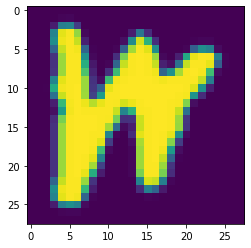

In [11]:
show_img(X[0])

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4,180)
        self.fc2 = nn.Linear(180,80)
        self.fc3 = nn.Linear(80,26)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = F.softmax(self.fc3(x), dim = -1)
        return x

model = Net().to("cuda")

In [13]:
demo_tensor = torch.rand(64,1,28,28, device='cuda')
model(demo_tensor).shape

torch.Size([64, 26])

In [14]:
#constants 

learning_rate = 0.01
batch_size = 64
epochs = 6

In [15]:
loss_fn = nn.CrossEntropyLoss()

In [16]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [17]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    size = len(train_dataloader.dataset)
    for batch, (x, y) in enumerate(train_dataloader):
        x = torch.unsqueeze(x ,1)
        x, y = x.to("cuda"), y.to("cuda")
        pred = model(x)
        loss = loss_fn(pred, y)
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(x)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
print('training finished')

Epoch 1
-------------------------------
loss: 5.328837  [    0/124800]
loss: 1.831570  [ 6400/124800]
loss: 1.048697  [12800/124800]
loss: 0.719578  [19200/124800]
loss: 0.502145  [25600/124800]
loss: 0.303658  [32000/124800]
loss: 0.368595  [38400/124800]
loss: 0.411579  [44800/124800]
loss: 0.324050  [51200/124800]
loss: 0.498865  [57600/124800]
loss: 0.555361  [64000/124800]
loss: 0.365463  [70400/124800]
loss: 0.587256  [76800/124800]
loss: 0.409623  [83200/124800]
loss: 0.338067  [89600/124800]
loss: 0.659792  [96000/124800]
loss: 0.354252  [102400/124800]
loss: 0.410724  [108800/124800]
loss: 0.375634  [115200/124800]
loss: 0.315309  [121600/124800]
Epoch 2
-------------------------------
loss: 0.229727  [    0/124800]
loss: 0.273487  [ 6400/124800]
loss: 0.238425  [12800/124800]
loss: 0.549547  [19200/124800]
loss: 0.263314  [25600/124800]
loss: 0.560152  [32000/124800]
loss: 0.255224  [38400/124800]
loss: 0.220784  [44800/124800]
loss: 0.250776  [51200/124800]
loss: 0.221181  [

In [18]:
torch.save(model, "noice.pth")

In [21]:
count = 0

m_test = X_test.shape[0]

with torch.no_grad():
    for (x, y) in test_dataloader:
        x = torch.unsqueeze(x, 1)
        x, y = x.to("cuda"), y.to("cuda")
        count += torch.sum(torch.argmax(model(x),1) == torch.argmax(y,1))

In [22]:
count

tensor(19164, device='cuda:0')

In [23]:
count/m_test * 100

tensor(92.1346, device='cuda:0')

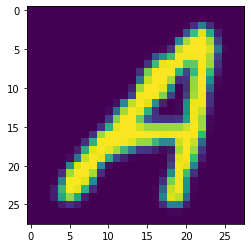

In [ ]:
show_img(X_test[1])

In [ ]:
a = 'a'
chr(ord(a) + 1)

'b'

In [39]:
rand_tensor = torch.rand(1,1,28,28,device='cuda')
model(rand_tensor).shape

torch.Size([1, 26])

'l'

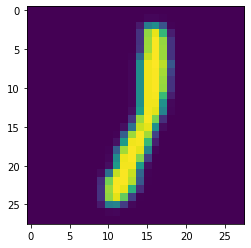

In [44]:
arr = X_test[9402]
show_img(arr)
test_tensor = (arr).to("cuda")
test_tensor = torch.unsqueeze(test_tensor, 0)
#test_tensor = torch.unsqueeze(test_tensor, 0)
letters = [chr(ord('a') + i) for i in range(26)]

letters[torch.argmax(model(test_tensor.unsqueeze(dim=0))).item()]

In [ ]:
letters[torch.argmax(Y_test[10000]).item()]

'm'

44
a


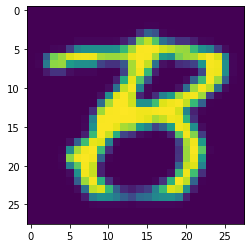

In [46]:
for i in range(42,m_test):
    arr = X_test[i]
    test_tensor = (arr).to("cuda")
    test_tensor = torch.unsqueeze(test_tensor, 0)
    pred = torch.argmax(model(test_tensor.unsqueeze(dim=0))).item() 
    truth = torch.argmax(Y_test[i]).item()
    if pred != truth:
        show_img(X[i])
        print(i)
        print(letters[truth])
        break



